# Flexibility in a Search Model 

## Model

- homogeneous workers with linear utility over wage $w(x;k)$ if employed and flow (dis)utility $b$ if unemployed
- heterogeneous firms endowed with flexibility level $k \in K = \{1,2,3\}$ costing $c(k)$ with linear profit $y(x;k)-w(x;k)-c(k)$
    - current assumption: $y(x;k) = kx$
- search parameters: discount rate $\rho$, unemployed meet firms at rate $\lambda$ (no on-the-job search), upon meeting draw match-specific productivity $x \sim G(x)$, bargaining parameter $\alpha$, employed face separation shock $\eta$


## Data Requirements 
- employed workers earn wage $w_i$ at firm with flexibility level $k$
- unemployed workers have unemployment durations of $t_i$
- flexibility level $k$ defined by 
    - 0: No flexibility in start and end times of work 
    - 1: Informal policy allowing flexibility in start and end times of work
    - 2: Formal policy allowing for flexibility in start and end times of work

In [1]:
# General
import numpy as np
import pandas as pd 
import scipy.stats as stats

# Graphics
import matplotlib.pyplot as plt 
import seaborn as sns

# Estimation
from scipy.optimize import minimize


In [2]:
df=pd.read_stata('workfile.dta', columns=['sex','employed', 'flex_sched_score', 'hrwage', 'dur']) #986,337 obs from 1984-2017; 711,205 for 2000-2017

## Inputs and Parameters

In [3]:
df['flex']=np.NaN
df['flex'].iloc[(df['flex_sched_score']==0)] = 0
df['flex'].iloc[(df['flex_sched_score']==1 )| (df['flex_sched_score']==2)] = 1

/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [4]:
df['flex_sched_score'].value_counts()

1.0    1219
0.0     829
2.0     406
Name: flex_sched_score, dtype: int64

In [5]:
df['flex'].value_counts()

1.0    1625
0.0     829
Name: flex, dtype: int64

In [6]:
df['flex_sched_score'].groupby(df['sex']).value_counts(normalize=True)

sex     flex_sched_score
male    1.0                 0.547504
        0.0                 0.274557
        2.0                 0.177939
female  1.0                 0.444719
        0.0                 0.402640
        2.0                 0.152640
Name: flex_sched_score, dtype: float64

In [7]:
df['sex'].value_counts()

male      1269
female    1239
Name: sex, dtype: int64

In [8]:
df['employed'].value_counts()

1.0    2454
0.0      54
Name: employed, dtype: int64

In [9]:
men = df[df['sex']=='male']
len(men)

1269

In [10]:
men['employed'].value_counts()

1.0    1242
0.0      27
Name: employed, dtype: int64

In [11]:
men['hrwage'].describe()

count    1242.000000
mean       42.517616
std        18.955248
min         0.008000
25%        26.923000
50%        39.423000
75%        58.173000
max        72.115250
Name: hrwage, dtype: float64

In [12]:
men['flex_sched_score'].describe()

count    1242.000000
mean        0.903382
std         0.665971
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: flex_sched_score, dtype: float64

In [13]:
men['dur'].describe()

count     27.000000
mean      18.629629
std       23.348774
min        8.000000
25%       12.000000
50%       12.000000
75%       16.000000
max      131.000000
Name: dur, dtype: float64

## Functions

In [14]:
def lognormpdf(x: np.array, μ: float, σ: float):
    """
    Calculates lognormal pdf without stats packages
    """
    
    denom = x * σ * np.sqrt(2*np.pi)
    exp_num = -(np.log(x)-μ)**2
    exp_denom = 2 * σ * σ
    num = np.exp(exp_num/exp_denom)
    
    return num/denom

In [15]:
def lognormsf(x: np.array, μ: float, σ: float):
    """
    Calculated lognormal cdf with scipy.stats normal cdf
    """
    
    lnx = np.log(x)
    num = lnx - μ
    denom = σ
    
    return 1-stats.norm.cdf(num/denom)

In [79]:
def Pr_wage_given_match(data: pd.DataFrame, flex: str, wage: str, res_wage: float, c_k: np.array, α: float, μ: float, σ: float):
# def Pr_wage_given_match(data: pd.DataFrame, flex: str, wage: str, res_wage: np.array, c_k: np.array, α: float, μ: np.array, σ: np.array):
    """
    Calculates probability of a wage draw conditional on a match being formed 
    
    Inputs
    - data: DataFrame
    - flex: string for name of flexibility column
    - wage: string for name of wage column
    - res_wage: Kx1 array of observed minimum wages for each flexibility level
    - c_k: Kx1 array of cost of providing flexibility
    - α: bargaining parameter
    - μ: array of location parameter of the log-normal wage distribution for each flexibility level
    - σ: array of scale parameter of the log-normal wage distribution for each flexibility level
    
    Functions
    - lognormpdf(x: np.array, μ: float, σ: float)
    - lognormsf(x: np.array, μ: float, σ: float)
    """
    employed_indiv = np.zeros(1) #sets first entry to zero 
# With U, μ and σ constant in flex level k
    for k in range(len(c_k)):
        tmp = data[data[flex]==k]
        g = ( 1/( α*(k+1) ) ) * lognormpdf( ( 1/( α*(k+1) ) )*( tmp[wage] - (1-α)*res_wage + α*c_k[k] ), μ, σ )
        G_tilde = lognormsf( ( 1/(k+1) )*( res_wage + c_k[k] ), μ, σ )
        divide_thing = g/G_tilde
        employed_indiv = np.append(employed_indiv, divide_thing)
# # With U, μ and σ varying with flex level k - unidentified    
#     for k in range(len(res_wage)):
#         tmp = data[data[flex]==k]
#         g = ( 1/( α*(k+1) ) ) * lognormpdf( ( 1/( α*(k+1) ) )*( tmp[wage] - (1-α)*res_wage[k] + α*c_k[k] ), μ[k], σ[k] )
#         G_tilde = lognormsf( ( 1/(k+1) )*( res_wage[k] + c_k[k] ), μ[k], σ[k] )
#         divide_thing = g/G_tilde
#         employed_indiv = np.append(employed_indiv, divide_thing)
    
    return employed_indiv[1:] #removes first entry 

In [111]:
def hazard(res_wage: float, c_k: np.array, p_k: np.array, λ: float, μ: float, σ: float):
# def hazard(res_wage: np.array, c_k: np.array, p_k: np.array, λ: float, μ: np.array, σ: np.array):
    """
    Calculates the hazard rate out of employment 
    
    Inputs
    - res_wage: Kx1 array of observed minimum wages for each flexibility level
    - c_k: Kx1 array of cost of providing flexibility
    - p_k: Kx1 array of probability of each level of flexibility
    - λ: arrival rate of offer
    - μ: array of location parameter of the log-normal wage distribution for each flexibility level
    - σ: array of scale parameter of the log-normal wage distribution for each flexibility level
    
    Functions
    - lognormsf(x: np.array, μ: float, σ: float)
    """
    
    prob_sum = 0
    
#     if len(res_wage)!=len(c_k):
#         return print("Length of res_wage and c_k do not match.")
#     elif len(res_wage)!=len(p_k):
#         return print("Length of res_wage and p_k do not match.")
    if len(p_k)!=len(c_k):
        return print("Length of p_k and c_k do not match.")
    else:
# With U, μ and σ constant in flex level k
        for k in range(len(c_k)):
            prob_sum += p_k[k] * lognormsf( ( 1/(k+1) )*( res_wage + c_k[k]), μ, σ ) #k+1 because Python index 0

# # With U, μ and σ varying with flex level k - unidentified    
#         for k in range(len(res_wage)):
#             prob_sum += p_k[k] * lognormsf( ( 1/(k+1) )*( res_wage[k] + c_k[k]), μ[k], σ[k] ) #k+1 because Python index 0
    
    return λ*prob_sum#[0]

In [81]:
def log_L(data: pd.DataFrame, flex: str, wage: str, dur: str, res_wage: float, c_k: np.array, p_k: np.array, α: float, λ: float, η: float, μ: float, σ: float):
# def log_L(data: pd.DataFrame, flex: str, wage: str, dur: str, res_wage: np.array, c_k: np.array, p_k: np.array, α: float, λ: float, η: float, μ: np.array, σ: np.array):
    """
    
    Inputs
    - data: DataFrame of all individuals
    - flex: string for column of flexibility index (k)
    - wage: string for column of wage data 
    - dur: string for unemployment duration data
    - res_wage: Kx1 array of observed minimum wages for each flexibility level
    - c_k: Kx1 array of cost of providing flexibility
    - p_k: Kx1 array of probability of each level of flexibility
    - α: bargaining parameter
    - λ: arrival rate of offer
    - η: termination rate
    - μ: array of location parameter of the log-normal wage distribution for each flexibility level
    - σ: array of scale parameter of the log-normal wage distribution for each flexibility level
    
    Functions
    - hazard(res_wage: np.array, c_k: np.array, p_k: np.array, λ: float, μ: float, σ: float)
    - Pr_wage_given_match(data: pd.DataFrame, flex: str, wage: str, res_wage: np.array, c_k: np.array,  α: float, μ: float, σ: float)
    """
    
    N_log_h = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) )
    N_log_h_plus_η = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) + η )
    
    empl_data = np.sum( np.log( Pr_wage_given_match(data, flex, wage, res_wage, c_k, α, μ, σ) ) )
    
    Nu_log_η = data[dur].count() * np.log(η)
    
    unempl_data = hazard(res_wage, c_k, p_k, λ, μ, σ) * np.sum(data[dur])
    
    logL = -(N_log_h - N_log_h_plus_η + empl_data + Nu_log_η - unempl_data)
    
    return logL[0]

## Optimization with 3 Levels of Flex - Not converging (cannot identify $c_k$, $\mu$, $\sigma$)

In [145]:
fifth_pctl = np.zeros(1)

for k in range(3):
    tmp = men[men['flex_sched_score']==k]
    fifth = np.percentile(tmp['hrwage'],5)
    fifth_pctl = np.append(fifth_pctl, fifth)
    print("5th percentile wage = " + str(fifth) + " for men with flex level " + str(k))

5th percentile wage = 13.0 for men with flex level 0
5th percentile wage = 17.49037504196167 for men with flex level 1
5th percentile wage = 18.0 for men with flex level 2


In [146]:
fifth_pctl[1:]

array([13.        , 17.49037504, 18.        ])

In [147]:
men['wage_trunc3']=men['hrwage']

for k in range(3):
    men['wage_trunc3'].iloc[(men['hrwage']<fifth_pctl[k+1]) & (men['flex_sched_score']==k)]=fifth_pctl[k+1] #k+1 because empty array initiates with zero
        

/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_20489/4041549448.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  men['wage_trunc3']=men['hrwage']
/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [148]:
men['wage_trunc3'].groupby([men['employed'],men['flex_sched_score']]).describe()

count       mean        std        min     25%  \
employed flex_sched_score                                                   
1.0      0.0               341.0  35.949913  17.789873  13.000000  22.500   
         1.0               680.0  45.039341  18.127398  17.490376  30.000   
         2.0               221.0  46.191139  18.594522  18.000000  30.048   

                                 50%        75%       max  
employed flex_sched_score                                  
1.0      0.0               31.250000  47.115250  72.11525  
         1.0               43.269001  61.538250  72.11525  
         2.0               43.748001  64.903748  72.11525

In [149]:
Uk = men.groupby('flex_sched_score').agg({'wage_trunc3': min}).values
Uk

array([[13.      ],
       [17.490376],
       [18.      ]], dtype=float32)

In [150]:
men['flex_sched_score'].value_counts(normalize=True, sort=False)

1.0    0.547504
0.0    0.274557
2.0    0.177939
Name: flex_sched_score, dtype: float64

In [151]:
prob_k = [0.274557, 0.547504, 0.177939]

In [152]:
# Parameters to be estimated 

c_k = np.array([0,5,10])
λ = 10
η = 10
μ = men['wage_trunc3'].mean()
σ = men['wage_trunc3'].std()
# μ = men['wage_trunc3'].groupby(men['flex_sched_score']).mean().values
# σ = men['wage_trunc3'].groupby(men['flex_sched_score']).std().values

In [153]:
μ

42.748722

In [154]:
σ

18.58707

In [155]:
params = np.array([c_k[1],c_k[2],λ,η,μ,σ])

# params = np.array([c_k[1],c_k[2],λ,η,μ[0],μ[1],μ[2],σ[0],σ[1],σ[2]])

In [162]:
men['wage_trunc3'].min()

13.0

In [164]:
# log_L(data: pd.DataFrame, flex: str, wage: str, dur: str, res_wage: np.array, c_k: np.array, p_k: np.array, α: float, λ: float, η: float, μ: np.array, σ: np.array)

log_L(men, 'flex_sched_score', 'wage_trunc3', 'dur', men['wage_trunc3'].min(), c_k, prob_k, 0.5, λ, η, μ, σ)    
    
# log_L(men, 'flex_sched_score', 'wage_trunc3', 'dur', Uk, c_k, prob_k, 0.5, λ, η, μ, σ)    

17642.00619890129

In [165]:
logL_opt = lambda x: log_L(men, 'flex_sched_score', 'wage_trunc3', 'dur', men['wage_trunc3'].min(), 
                            np.array([0,x[0],x[1]]), prob_k, 0.5, x[2], x[3],
                            x[4], x[5])

In [166]:
minimize(logL_opt, params, method='Nelder-Mead')

/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_20489/69207791.py:27: RuntimeWarning: invalid value encountered in log
  empl_data = np.sum( np.log( Pr_wage_given_match(data, flex, wage, res_wage, c_k, α, μ, σ) ) )
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_20489/69207791.py:27: RuntimeWarning: divide by zero encountered in log
  empl_data = np.sum( np.log( Pr_wage_given_match(data, flex, wage, res_wage, c_k, α, μ, σ) ) )
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_20489/69207791.py:29: RuntimeWarning: invalid value encountered in log
  Nu_log_η = data[dur].count() * np.log(η)
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_20489/69207791.py:25: RuntimeWarning: invalid value encountered in log
  N_log_h_plus_η = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) + η )
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_20489/69207791.py:24: RuntimeWarning: invalid value encountered in log
  N_log_h = data.count() * np.

 final_simplex: (array([[2.29759182e+01, 3.81659796e+01, 5.55469736e-02, 1.16855848e-03,
        3.77626280e+00, 5.09872940e-01],
       [2.29760024e+01, 3.81660116e+01, 5.54944276e-02, 1.16729139e-03,
        3.77631059e+00, 5.09924796e-01],
       [2.29758879e+01, 3.81659634e+01, 5.55444800e-02, 1.16982553e-03,
        3.77632540e+00, 5.09866551e-01],
       [2.29759898e+01, 3.81659999e+01, 5.55230648e-02, 1.16838906e-03,
        3.77624269e+00, 5.09918447e-01],
       [2.29759720e+01, 3.81659390e+01, 5.55481973e-02, 1.16944554e-03,
        3.77628472e+00, 5.09963570e-01],
       [2.29759553e+01, 3.81659965e+01, 5.55163339e-02, 1.16816270e-03,
        3.77630367e+00, 5.09895099e-01],
       [2.29759176e+01, 3.81659312e+01, 5.55720409e-02, 1.16926884e-03,
        3.77626696e+00, 5.09918566e-01]]), array([5632.28893146, 5632.28893503, 5632.28895975, 5632.28896579,
       5632.28898718, 5632.28899216, 5632.2890272 ]))
           fun: 5632.288931457506
       message: 'Optimization termi

## Try with 2 levels of flex - same problem as with 3 levels of flex.

In [55]:
fifth_pctl = np.zeros(1)

for k in range(2):
    tmp = men[men['flex']==k]
    fifth = np.percentile(tmp['hrwage'],5)
    fifth_pctl = np.append(fifth_pctl, fifth)
    print("5th percentile wage = " + str(fifth) + " for men with flex level " + str(k))

5th percentile wage = 13.0 for men with flex level 0
5th percentile wage = 17.5 for men with flex level 1


In [56]:
fifth_pctl[1:]

array([13. , 17.5])

In [58]:
men['wage_trunc2']=men['hrwage']

for k in range(2):
    men['wage_trunc2'].iloc[(men['hrwage']<fifth_pctl[k+1]) & (men['flex']==k)]=fifth_pctl[k+1] #k+1 because empty array initiates with zero
        

/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_20489/3523321040.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  men['wage_trunc2']=men['hrwage']


In [64]:
Uk = men.groupby('flex').agg({'wage_trunc2': min}).values
Uk

array([[13. ],
       [17.5]], dtype=float32)

In [65]:
men['flex'].value_counts(normalize=True, sort=False)

1.0    0.725443
0.0    0.274557
Name: flex, dtype: float64

In [182]:
prob_k = np.array([0.274557, 0.725443])

In [183]:
# Parameters to be estimated 

c_k = np.array([0,1])
λ = 2.1
η = 2.1
μ = men['wage_trunc2'].mean()
σ = men['wage_trunc2'].std()
# μ = men['wage_trunc2'].groupby(men['flex']).mean().values
# σ = men['wage_trunc2'].groupby(men['flex']).std().values

In [184]:
μ

42.744556

In [185]:
σ

18.592672

In [186]:
params = np.array([c_k[1],λ,η,μ,σ])

# params = np.array([c_k[0],c_k[1],λ,η,μ[0],μ[1],σ[0],σ[1]])

In [187]:
log_L(men, 'flex', 'wage_trunc2', 'dur', men['wage_trunc2'].min(), np.array([0,params[0]]), prob_k, 0.5, params[1], params[2], params[3], params[4])


# log_L(men, 'flex', 'wage_trunc2', 'dur', Uk, np.array([params[0],params[1]]), prob_k, 0.5, params[2], params[3], np.array([params[4],params[5]]), np.array([params[6], params[7]]))

13691.501941581386

In [188]:
logL_opt = lambda x: log_L(men, 'flex', 'wage_trunc2', 'dur', men['wage_trunc2'].min(), 
                            np.array([0,x[0]]), prob_k, 0.5, x[1], x[2],
                            x[3],x[4])

In [189]:
logL_opt(params)

13691.501941581386

In [190]:
minimize(logL_opt, params, method='Nelder-Mead')

/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_20489/69207791.py:29: RuntimeWarning: invalid value encountered in log
  Nu_log_η = data[dur].count() * np.log(η)
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_20489/69207791.py:25: RuntimeWarning: invalid value encountered in log
  N_log_h_plus_η = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) + η )
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_20489/69207791.py:27: RuntimeWarning: divide by zero encountered in log
  empl_data = np.sum( np.log( Pr_wage_given_match(data, flex, wage, res_wage, c_k, α, μ, σ) ) )
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_20489/69207791.py:24: RuntimeWarning: invalid value encountered in log
  N_log_h = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) )


 final_simplex: (array([[3.84603483e+00, 5.42042637e-02, 1.16713453e-03, 3.65298114e+00,
        5.83016183e-01],
       [3.84602746e+00, 5.42353656e-02, 1.16784643e-03, 3.65295478e+00,
        5.83030846e-01],
       [3.84603578e+00, 5.42010444e-02, 1.16668920e-03, 3.65295679e+00,
        5.83023809e-01],
       [3.84603103e+00, 5.42272061e-02, 1.16721921e-03, 3.65297666e+00,
        5.82984555e-01],
       [3.84603115e+00, 5.42243975e-02, 1.16768501e-03, 3.65298639e+00,
        5.82987617e-01],
       [3.84602777e+00, 5.42352945e-02, 1.16765374e-03, 3.65300801e+00,
        5.83009060e-01]]), array([5597.35042039, 5597.35044325, 5597.35045388, 5597.35049617,
       5597.35051518, 5597.3505166 ]))
           fun: 5597.350420388368
       message: 'Optimization terminated successfully.'
          nfev: 855
           nit: 516
        status: 0
       success: True
             x: array([3.84603483e+00, 5.42042637e-02, 1.16713453e-03, 3.65298114e+00,
       5.83016183e-01])

# Figures

## Flex Schedule Score (k = 3)

/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a

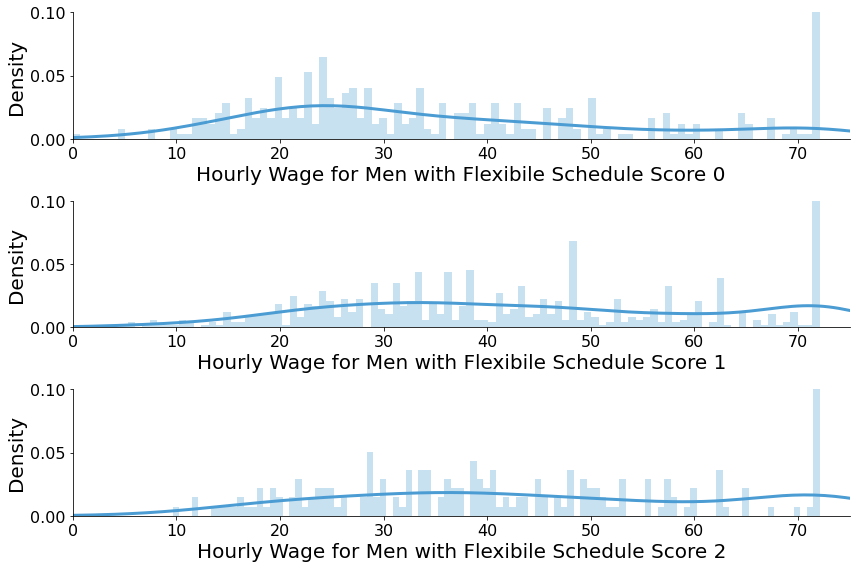

In [44]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8))

for k in range(3):
    tmp = df[(df['flex_sched_score']==k) & (df['sex']=='male') & (df['employed']==1)]
    sns.distplot(tmp['hrwage'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=100, ax=ax[k])
#     ax[k].legend(['Flexibility Level ' + str(k)])
    ax[k].set_ylim([0,0.1])
    ax[k].set_xlim([0,75])
    ax[k].set(xlabel = 'Hourly Wage for Men with Flexibile Schedule Score ' +str(k))

# ax.set(xlabel="Distribution of Men's Hourly Wage (raw)")

plt.tight_layout()

fig.savefig('./hrwage_men_3flex.png', bbox_inches='tight', transparent=True)

/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a

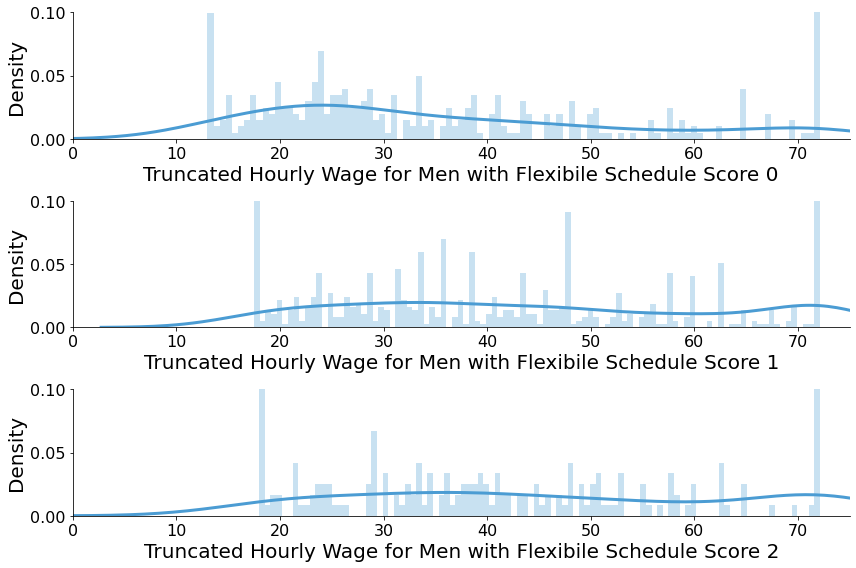

In [45]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8))

for k in range(3):
    tmp = men[(men['flex_sched_score']==k) & (men['employed']==1)]
    sns.distplot(tmp['wage_trunc'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=100, ax=ax[k])
#     ax[k].legend(['Flex Level ' + str(k)])
    ax[k].set_ylim([0,0.1])
    ax[k].set_xlim([0,75])
    ax[k].set(xlabel = 'Truncated Hourly Wage for Men with Flexibile Schedule Score ' +str(k))

#ax.set(xlabel="Distribution of Men's Hourly Wage")

plt.tight_layout()

fig.savefig('./wageTrunc_men_3flex.png', bbox_inches='tight', transparent=True)

## Binary Flexibility Measure

/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


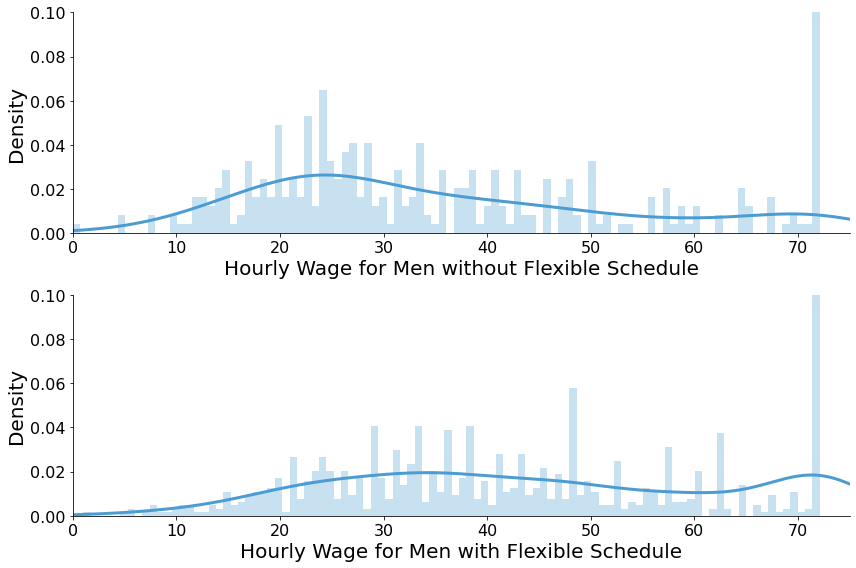

In [78]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

for k in range(2):
    tmp = df[(df['flex']==k) & (df['sex']=='male') & (df['employed']==1)]
    sns.distplot(tmp['hrwage'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=100, ax=ax[k])
#     ax[k].legend(['Flexibility Level ' + str(k)])
    ax[k].set_ylim([0,0.1])
    ax[k].set_xlim([0,75])
    if k == 1:
        ax[k].set(xlabel = 'Hourly Wage for Men with Flexible Schedule')
    elif k == 0:
        ax[k].set(xlabel = 'Hourly Wage for Men without Flexible Schedule')
    else:
        print("Not binary k")

# ax.set(xlabel="Distribution of Men's Hourly Wage (raw)")

plt.tight_layout()

fig.savefig('./hrwage_men_2flex.png', bbox_inches='tight', transparent=True)

/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


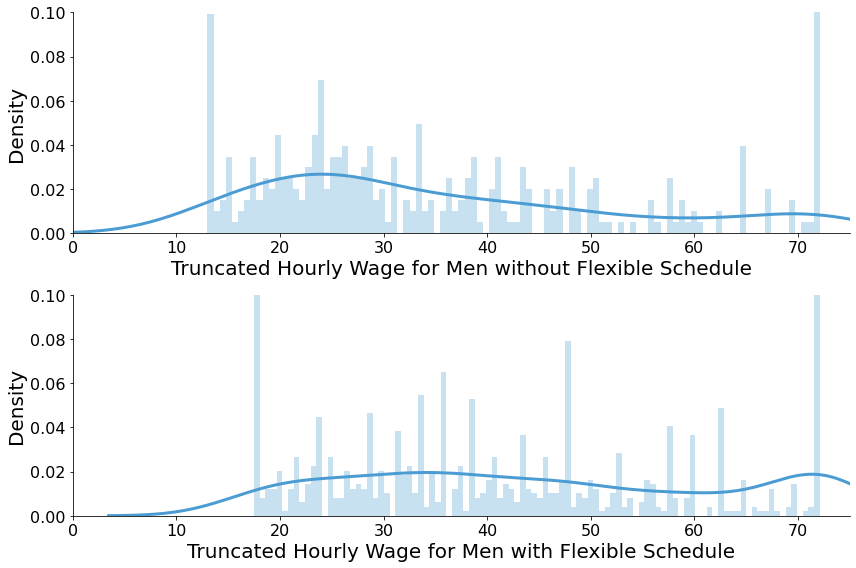

In [77]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

for k in range(2):
    tmp = men[(men['flex']==k) & (men['employed']==1)] #(df['sex']=='male') & 
    sns.distplot(tmp['wage_trunc'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=100, ax=ax[k])
#     ax[k].legend(['Flexibility Level ' + str(k)])
    ax[k].set_ylim([0,0.1])
    ax[k].set_xlim([0,75])
    if k == 1:
        ax[k].set(xlabel = 'Truncated Hourly Wage for Men with Flexible Schedule')
    elif k == 0:
        ax[k].set(xlabel = 'Truncated Hourly Wage for Men without Flexible Schedule')
    else:
        print("Not binary k")

# ax.set(xlabel="Distribution of Men's Hourly Wage (raw)")

plt.tight_layout()

fig.savefig('./wagetrunc_men_2flex.png', bbox_inches='tight', transparent=True)

# Summary Statistics

In [191]:
agg_dict_empl = {
    'hrwage': ['min', 'mean', 'std', 'count']
}

agg_dict_unempl = {
    'dur': ['mean', 'std', 'count']
}

agg_dict_pos = {
    'flex_sched_score': ['count'] #want to add percent!
}

In [192]:
print(men.groupby(['flex_sched_score']).agg(agg_dict_pos).to_latex()) # by gender

\begin{tabular}{lr}
\toprule
{} & flex\_sched\_score \\
{} &            count \\
flex\_sched\_score &                  \\
\midrule
0.0              &              341 \\
1.0              &              680 \\
2.0              &              221 \\
\bottomrule
\end{tabular}



In [193]:
print(men.groupby(['flex_sched_score']).agg(agg_dict_empl).to_latex()) # by gender

\begin{tabular}{lrrrr}
\toprule
{} & \multicolumn{4}{l}{hrwage} \\
{} &    min &       mean &        std & count \\
flex\_sched\_score &        &            &            &       \\
\midrule
0.0              &  0.008 &  35.783260 &  18.035790 &   341 \\
1.0              &  1.020 &  44.760174 &  18.610607 &   680 \\
2.0              &  9.625 &  46.008465 &  18.894679 &   221 \\
\bottomrule
\end{tabular}



In [ ]:
print(empl_df.groupby(['female']).agg(agg_dict_empl).to_latex()) # all

In [ ]:
print(unempl_df.groupby(['female']).agg(agg_dict_unempl).to_latex()) # by gender

In [ ]:
print(unempl_df.agg(agg_dict_unempl).to_latex()) # by gender

# Scratch

In [142]:
# Parameters to be estimated 

c_k = np.array([0,5,10])
λ = 2.1
η = 2.1
μ = men['hrwage'].groupby(men['flex_sched_score']).mean().values
σ = men['hrwage'].groupby(men['flex_sched_score']).std().values

In [137]:
logL_opt = lambda x: log_L(men, 'flex_sched_score', 'hrwage', 'dur', Uk, 
                            x[0], prob_k, 0.5, x[1], x[2],
                            x[3], x[4])

In [135]:
params = np.array([c_k, float(λ), float(η), μ, σ])
params

/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_17163/3712735007.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  params = np.array([c_k, float(λ), float(η), μ, σ])


array([array([ 0,  5, 10]), 2.1, 2.1,
       array([35.78326 , 44.760174, 46.008465], dtype=float32),
       array([18.03579008, 18.61060744, 18.89467893])], dtype=object)

In [136]:
params[1]

2.1

In [138]:
log_L(men, 'flex_sched_score', 'hrwage', 'dur', Uk, 
                            params[0], prob_k, 0.5, params[1], params[2],
                            params[3], params[4])

-13025.611559912093

In [139]:
logL_opt(params)

-13025.611559912093

## Old Hazard and Log L (did not copy Pr_wage_match in time)

In [ ]:
def hazard(res_wage: np.array, c_k: np.array, p_k: np.array, λ: float, μ: np.array, σ: np.array):
    """
    Calculates the hazard rate out of employment 
    
    Inputs
    - res_wage: Kx1 array of observed minimum wages for each flexibility level
    - c_k: Kx1 array of cost of providing flexibility
    - p_k: Kx1 array of probability of each level of flexibility
    - λ: arrival rate of offer
    - μ: array of location parameter of the log-normal wage distribution for each flexibility level
    - σ: array of scale parameter of the log-normal wage distribution for each flexibility level
    
    Functions
    - lognormsf(x: np.array, μ: float, σ: float)
    """
    
    prob_sum = 0
    
    if len(res_wage)!=len(c_k):
        return print("Length of res_wage and c_k do not match.")
    elif len(res_wage)!=len(p_k):
        return print("Length of res_wage and p_k do not match.")
    elif len(p_k)!=len(c_k):
        return print("Length of p_k and c_k do not match.")
    else:
        for k in range(len(res_wage)):
            prob_sum += p_k[k] * lognormsf( ( 1/(k+1) )*( res_wage[k] + c_k[k]), μ[k], σ[k] ) #k+1 because Python index 0
    
    return λ*prob_sum

In [ ]:
def log_L(wage: np.array, k: np.array, res_wage: np.array, c_k: np.array, p_k: np.array, dur: np.array, α: float, λ: float, η: float, μ: np.array, σ: np.array):
    """
    
    Inputs
    - wage: Ne x 1 array of observed wage data 
    - k: Ne x 1 array of observed flexibility level data
    - res_wage: Kx1 array of observed minimum wages for each flexibility level
    - c_k: Kx1 array of cost of providing flexibility
    - p_k: Kx1 array of probability of each level of flexibility
    - dur: Nu x 1 array of observed unemployment duration data
    - α: bargaining parameter
    - λ: arrival rate of offer
    - η: termination rate
    - μ: array of location parameter of the log-normal wage distribution for each flexibility level
    - σ: array of scale parameter of the log-normal wage distribution for each flexibility level
    
    Functions
    - hazard(res_wage: np.array, c_k: np.array, p_k: np.array, λ: float, μ: float, σ: float)
    - Pr_wage_given_match(wage: np.array, k: np.array, res_wage: np.array, c_k: np.array,  α: float, μ: float, σ: float)
    """
    
    N_log_h = len(wage) * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) )
    N_log_h_plus_η = len(wage) * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) + η )
    
    empl_data = np.sum( np.log( Pr_wage_given_match(wage, k, res_wage, c_k,  α, μ, σ) ) )
    
    Nu_log_η = len(dur) * np.log(η)
    
    unempl_data = hazard(res_wage, c_k, p_k, λ, μ, σ) * np.sum(dur)
    
    logL = N_log_h - N_log_h_plus_η + empl_data + Nu_log_η - unempl_data
    
    return logL

In [ ]:
empl_men = men[men['employed']==1]
len(empl_men)

In [ ]:
unempl_men = men[men['employed']==0]
len(unempl_men)

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8))

for k in range(3):
    tmp = df[(df['flex_sched_score']==k) & (df['sex']=='female') & (df['employed']==1)]
    sns.distplot(tmp['hrwage'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=100, ax=ax[k])
    ax[k].legend(['Flex Level ' + str(k)])
    ax[k].set_ylim([0,0.1])
    ax[k].set_xlim([0,75])


#ax.set(xlabel="Distribution of Men's Hourly Wage")

plt.tight_layout()

# fig.savefig('./figures/wage_noMin.png', bbox_inches='tight', transparent=True)